In [1]:
#utilities
import re
import numpy as np
import pandas as pd
# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
# nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.stem import LancasterStemmer
# sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
df=pd.read_csv("Tweets.csv")

In [3]:
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [4]:
df.shape

(14640, 15)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

In [6]:
df.dtypes

tweet_id                          int64
airline_sentiment                object
airline_sentiment_confidence    float64
negativereason                   object
negativereason_confidence       float64
airline                          object
airline_sentiment_gold           object
name                             object
negativereason_gold              object
retweet_count                     int64
text                             object
tweet_coord                      object
tweet_created                    object
tweet_location                   object
user_timezone                    object
dtype: object

In [7]:
df.isnull().sum(axis=0)

tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64

In [8]:
df.columns

Index(['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline',
       'airline_sentiment_gold', 'name', 'negativereason_gold',
       'retweet_count', 'text', 'tweet_coord', 'tweet_created',
       'tweet_location', 'user_timezone'],
      dtype='object')

In [9]:
df['airline_sentiment'].unique()

array(['neutral', 'positive', 'negative'], dtype=object)

In [10]:
df['airline_sentiment'].nunique()

3

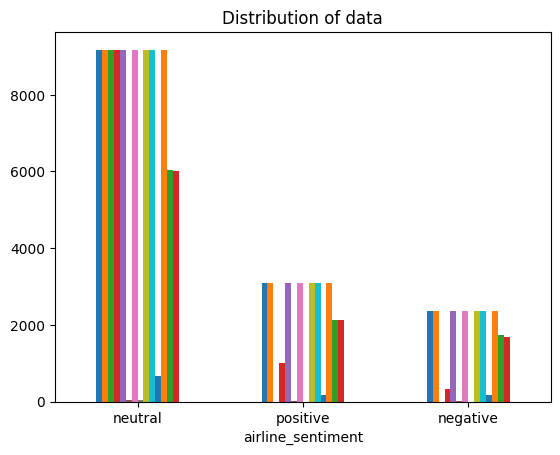

In [11]:
# Plotting the distribution for dataset.
ax = df.groupby('airline_sentiment').count().plot(kind='bar', title='Distribution of data',legend=False)
ax.set_xticklabels(['neutral', 'positive', 'negative'], rotation=0)
# Storing data in lists.
text, sentiment = list(df['text']), list(df['airline_sentiment'])

<Axes: xlabel='airline_sentiment', ylabel='count'>

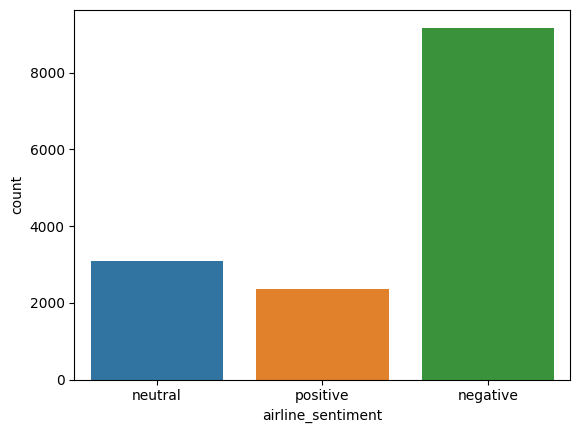

In [12]:
import seaborn as sns
sns.countplot(x='airline_sentiment', data=df)

In [13]:
data=df[['text','airline_sentiment']]

In [14]:
data_pos = data[data['airline_sentiment'] == 'positive']
data_neg = data[data['airline_sentiment'] == 'negative']
data_neu = data[data['airline_sentiment'] == 'neutral']

In [15]:
dataset = pd.concat([data_pos, data_neg, data_neu])

In [16]:
dataset['text']=dataset['text'].str.lower()
dataset['text'].tail()

14607           @americanair i need someone to help me out
14611    @americanair guarantee no retribution? if so, ...
14632    “@americanair: @tilleymonsta george, that does...
14637    @americanair please bring american airlines to...
14639    @americanair we have 8 ppl so we need 2 know h...
Name: text, dtype: object

In [17]:
stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from',
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're',
              's', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those',
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

In [18]:
STOPWORDS = set(stopwordlist)
def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])
dataset['text'] = dataset['text'].apply(lambda text: cleaning_stopwords(text))
dataset['text'].head()

1     @virginamerica plus you've added commercials e...
6     @virginamerica yes, nearly every time fly vx “...
8               @virginamerica well, didn't…but do! :-d
9     @virginamerica amazing, arrived hour early. yo...
11    @virginamerica &lt;3 pretty graphics. much bet...
Name: text, dtype: object

In [19]:
import string
english_punctuations = string.punctuation
punctuations_list = english_punctuations
def cleaning_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)
dataset['text']= dataset['text'].apply(lambda x: cleaning_punctuations(x))
dataset['text'].head()

1     virginamerica plus youve added commercials exp...
6     virginamerica yes nearly every time fly vx “ea...
8                     virginamerica well didnt…but do d
9     virginamerica amazing arrived hour early youre...
11    virginamerica lt3 pretty graphics much better ...
Name: text, dtype: object

In [20]:
def cleaning_repeating_char(text):
    return re.sub(r'(.)1+', r'1', text)
dataset['text'] = dataset['text'].apply(lambda x: cleaning_repeating_char(x))
dataset['text'].tail()

14607                        americanair need someone help
14611    americanair guarantee no retribution so id gla...
14632    “americanair tilleymonsta george doesnt look g...
14637    americanair please bring american airlines bla...
14639    americanair 8 ppl need 2 know many seats next ...
Name: text, dtype: object

In [21]:
def cleaning_URLs(data):
    return re.sub('((www.[^s]+)|(https?://[^s]+))',' ',data)
dataset['text'] = dataset['text'].apply(lambda x: cleaning_URLs(x))
dataset['text'].tail()

14607                        americanair need someone help
14611    americanair guarantee no retribution so id gla...
14632    “americanair tilleymonsta george doesnt look g...
14637    americanair please bring american airlines bla...
14639    americanair 8 ppl need 2 know many seats next ...
Name: text, dtype: object

In [22]:
def cleaning_numbers(data):
    return re.sub('[0-9]+', '', data)
dataset['text'] = dataset['text'].apply(lambda x: cleaning_numbers(x))
dataset['text'].tail()

14607                        americanair need someone help
14611    americanair guarantee no retribution so id gla...
14632    “americanair tilleymonsta george doesnt look g...
14637    americanair please bring american airlines bla...
14639    americanair  ppl need  know many seats next fl...
Name: text, dtype: object

In [23]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import RegexpTokenizer
token=RegexpTokenizer(r'[a-zA-Z0-9]+')
cv=CountVectorizer(stop_words='english', ngram_range=(1,1), tokenizer = token.tokenize)
text_counts=cv.fit_transform(dataset['text'])

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [24]:
# Set up training and test sets by choosing random samples from classes
X_train, X_test, y_train, y_test = train_test_split(text_counts, df['text'], test_size=0.33, random_state=0)

In [25]:
X_train.shape

(9808, 14524)

In [26]:
from sklearn.naive_bayes import MultinomialNB

In [27]:
MNB=MultinomialNB()
MNB.fit(X_train,y_train)

MultinomialNB()

In [28]:
from sklearn import metrics
predicted = MNB.predict(X_test)
accuracy_score=metrics.accuracy_score(predicted, y_test)
print(accuracy_score)

0.0


In [29]:
print(str('{:04.2f}'.format(accuracy_score*100))+'%')

0.00%
